### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
#using Distributions
using MDToolbox

In [2]:
function _mbar_f(u_kl, f_k, u_k=nothing)
    # K: number of umbrella windows
    K, L = size(u_kl)

    # N_k: number of data in k-th umbrella window
    N_k = zeros(Int64, K)
    for k = 1:K
        N_k[k] = length(u_kl[k, 1])
    end
    N_max = maximum(N_k)
    
    # conversion from array of array (u_kl) to array (u_kln)
    u_kln = zeros(Float64, K, K, N_max)
    for k = 1:K
        for l = 1:K
            u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
        end
    end

    # conversion from cell (u_k) to array (u_kn)
    u_kn = zeros(Float64, K, N_max)
    for k = 1:K
        if u_k === nothing
            u_kn[1, 1:N_k[k]] .= zero(Float64)
        else
            u_kn[k, 1:N_k[k]] .= u_k[k]
        end
    end

    log_w_kn = zeros(Float64, K, N_max)
    for k = 1:K
      log_w_kn[k, 1:N_k[k]] .= 1.0
    end
    idx = log_w_kn .> 0.5;

    log_w_kn = MDToolbox.mbar_log_wi_jn(N_k, f_k, u_kln, u_kn, K, N_max)
    f_hat = - MDToolbox.logsumexp_1d(log_w_kn[idx])

    return f_hat
end

function ChainRulesCore.rrule(::typeof(_mbar_f), u_kl, f_k, u_k)
    f_hat = _mbar_f(u_kl, f_k, u_k)
    w_k = MDToolbox.mbar_weight(u_kl, f_k, u_k)
    function _mbar_f_pullback(df)
        println("size(df):$(size(df))")
        du_k = deepcopy(w_k)
        for k = 1:length(w_k)
            for n = 1:length(w_k[k])
                du_k[k][n] = exp(f_hat) * w_k[k][n] * df
            end
        end
        println("size(du_k):$(size(du_k))")
        println("size(du_k[1]):$(size(du_k[1]))")
        println(maximum(du_k[1]))
        return NoTangent(), ZeroTangent(), NoTangent(), du_k
    end
    return f_hat, _mbar_f_pullback
end

### ポテンシャルエネルギー関数の定義

In [3]:
#2原子の距離を用いポテンシャルを計算
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

#nステップ目のポテンシャルを計算
function sum_compute_energy(coords, epsilon, sigma)
    U = 0
    for i in 1:size(coords, 1)
        for j in (i+1):size(coords, 1)
            U += compute_energy(coords[i], coords[j], epsilon, sigma)
        end
    end
    return U
end

sum_compute_energy (generic function with 1 method)

In [4]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        println(size(dU))
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [5]:
"""
function ChainRulesCore.rrule(::typeof(sum_compute_energy), coords, epsilon, sigma)
    U = sum_compute_energy(coords, epsilon, sigma)
    function sum_compute_energy_pullback(du_k)
        println("size(du_k)")
        
        return NoTangent(), NoTangent(), depsilon, dsigma
    end
    return U, sum_compute_energy_pullback
end
"""

In [6]:
#n原子の軌跡からFを計算
#coords_trj = data_k[i]
function compute_free_energy(coords_trj, beta, epsilon, sigma)
    N = size(coords_trj, 1) #ステップ数
    U_array = [sum_compute_energy(coords_trj[i], epsilon, sigma) for i in 1:N] #Nステップのポテンシャルの値を入れた配列
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array)) #U_arrayを積分してFを計算
    return F
end

compute_free_energy (generic function with 1 method)

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

### MCMCの定義

In [7]:
#次のステップ候補点
function next_coords(coords, delta_x=1e-2)
    next_coords = map(x -> x .+ (rand(3) .- 0.5) .* delta_x, coords)
    return next_coords
end

next_coords (generic function with 2 methods)

In [8]:
#MCMC,メトロポリス法
function mcmc(coords, epsilon, sigma, nstep=100, beta=1.0, delta_x=1e-2)
    coords_trj = []
    alpha_trj = []
    push!(coords_trj, copy.(coords))
    
    for i in 1:nstep
        next_coords_tmp = next_coords(coords, delta_x) #候補点
        delta_U = sum_compute_energy(next_coords_tmp, epsilon, sigma) - sum_compute_energy(coords, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords = next_coords_tmp
        end     
        push!(coords_trj, copy.(coords))
        push!(alpha_trj, alpha)
    end
    return coords_trj, alpha_trj
end

mcmc (generic function with 4 methods)

### 訓練データの作成

In [9]:
#パラメータ
param_set = [(1.3, 2.3),(1.0, 2.0)] #params_set[i] = (epsilon[i], sigma[i])

data_k = []
alpha_trj = []
K = size(param_set, 1) #最後のパラメータの値を推定する
natom = 3
kBT = 0.1
beta = 1.0/(kBT)
nstep = 10000
delta_x = 1e-2

for i in 1:size(param_set, 1)
    use_param = i #使うパラメータ
    epsilon = param_set[use_param][1]
    sigma = param_set[use_param][2]

    coords = [[[sigma * x + rand(), rand(), rand()] for x in 1:natom]...]  #初期座標

    #nstepのMCMC
    coords_trj, alpha = mcmc(coords, epsilon, sigma, nstep, beta, delta_x)
    push!(data_k, coords_trj)
    push!(alpha_trj, alpha)
end

### MBAR

In [10]:
u_kl = Array{Any}(undef, (K, K))
nstep = size(data_k[1], 1)

for k in 1:K
    for l in 1:K #F_targetもMBARで推定する
        #k番目のtrjデータをl番目のパラメータを用いポテンシャルを計算
        #xは何ステップ目を表す変数
        u_kl[k, l] = [sum_compute_energy(data_k[k][x], param_set[l][1], param_set[l][2]) for x in 1:nstep]
    end
end      

In [11]:
# solve MBAR equations
f_k = mbar(u_kl)

iteration = 1  delta = 1.414214e+00  tol = 1.000000e-08
free energies =  0.000000 -0.039451

iteration = 2  delta = 4.123091e-01  tol = 1.000000e-08
free energies =  0.000000 -0.055686

iteration = 3  delta = 1.528973e-01  tol = 1.000000e-08
free energies =  0.000000 -0.062436

iteration = 4  delta = 6.108251e-02  tol = 1.000000e-08
free energies =  0.000000 -0.065254

iteration = 5  delta = 2.509510e-02  tol = 1.000000e-08
free energies =  0.000000 -0.066433

iteration = 6  delta = 1.042649e-02  tol = 1.000000e-08
free energies =  0.000000 -0.066927

iteration = 7  delta = 4.352050e-03  tol = 1.000000e-08
free energies =  0.000000 -0.067133

iteration = 8  delta = 1.820054e-03  tol = 1.000000e-08
free energies =  0.000000 -0.067220

iteration = 9  delta = 7.617681e-04  tol = 1.000000e-08
free energies =  0.000000 -0.067256

iteration = 10  delta = 3.189386e-04  tol = 1.000000e-08
free energies =  0.000000 -0.067271

iteration =11  delta = 2.297984e-05  tol = 1.000000e-08
free energies

2-element Vector{Float64}:
  0.0
 -0.06728212214971191

In [12]:
# Sanity check
F = [compute_free_energy(data_k[i], beta, param_set[i][1], param_set[i][2]) for i in 1:K] 
@show F .- F[1]

F .- F[1] = [0.0, 0.568251918896254]


2-element Vector{Float64}:
 0.0
 0.568251918896254

In [13]:
epsilon_target = 1.1
sigma_target = 4.1

coords_target = [[[rand(), rand(), rand()] for x in 1:natom]...]
trj_target, alpha = mcmc(coords_target, epsilon_target, sigma_target, nstep, beta)

@show F_target = compute_free_energy(trj_target, beta, epsilon_target, sigma_target)

@show delta_F = F_target - F[1]

F_target = compute_free_energy(trj_target, beta, epsilon_target, sigma_target) = -3.193996999388191
delta_F = F_target - F[1] = -0.7100059466840589


-0.7100059466840589

In [14]:
# Sanity check
u_k = Vector{Any}(undef, K)

for k in 1:K    
    u_k[k] = [sum_compute_energy(data_k[k][x], epsilon_target, sigma_target) for x in 1:nstep]
end

f_target = mbar_f(u_kl, f_k, u_k)
@show f_target
(1 ./ beta) * (f_target - f_k[1])

f_target = 570.0555075853356


57.00555075853356

In [15]:
#パラメータ推定に用いる原子の軌跡と自由エネルギーの差
X_train = []
for k = 1:K
    push!(X_train, (data_k[k]))
end
y_train = delta_F

-0.7100059466840589

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [16]:
function compute_deltaF(X, f_k, u_kl, beta, epsilon, sigma)
    #K = length(f_k)
    #u_k = Vector{Vector{Float64}}(undef, 0)
    #for k = 1:K
        #for istep = 1:nstep
        #    u_k[k][istep] = beta * compute_energy(X[1][k][istep], X[2][k][istep], m.P[1], m.P[2])
        #end
        #push!(u_k, map(x -> beta * compute_energy(x[1], x[2], epsilon, sigma), zip(X[1][k], X[2][k])))
    #end
    for k in 1:K
        for istep in 1:nstep
            u_k[k][istep] = sum_compute_energy(X[k][istep], epsilon, sigma)
        end
    end
    f_target = _mbar_f(u_kl, f_k, u_k)
    delta_F = (1 ./ beta) * (f_target - f_k[1])
    return delta_F
end

compute_deltaF (generic function with 1 method)

In [17]:
struct MBAR
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor MBAR (P,)

(m::MBAR)(X) = compute_deltaF(X, f_k, u_kl, beta, m.P[1], m.P[2])


In [18]:
# Sanity check
m = MBAR([epsilon_target, sigma_target])
loss(X, y) = Flux.Losses.mse(m(X), y)
loss(X_train, y_train)

3331.08548579319

In [19]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3) 

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [20]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [21]:
# 訓練
loss_train = []

for epoch in 1:11
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    push!(loss_train, loss(X_train, y_train))
    if epoch%10 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

size(df):()
size(du_k):(2,)
size(du_k[1]):(10001,)
2.5931412036083424e248


LoadError: Mutating arrays is not supported -- called setindex!(Vector{Float64}, ...)
This error occurs when you ask Zygote to differentiate operations that change
the elements of arrays in place (e.g. setting values with x .= ...)

Possible fixes:
- avoid mutating operations (preferred)
- or read the documentation and solutions for this error
  https://fluxml.ai/Zygote.jl/latest/limitations


In [22]:
loss(X_train, y_train)

3331.08548579319

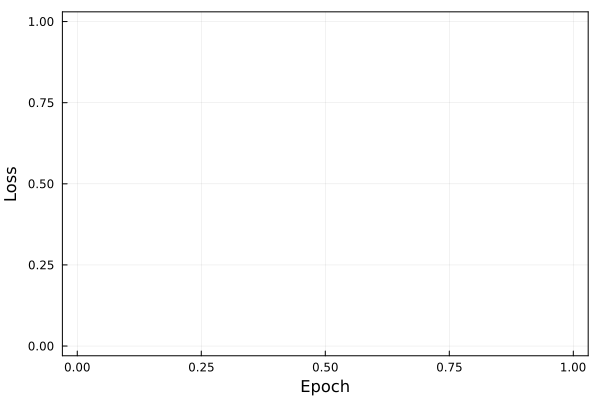

In [23]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [24]:
println("Ground-truth epsilon: ", epsilon_true)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_true)
println("Estimate sigma:     ", m.P[2])

LoadError: UndefVarError: `epsilon_true` not defined

In [25]:
1/(sum(sum(a)))

LoadError: UndefVarError: `a` not defined